In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras_utils import LRFinder, SGDRScheduler, CyclicLR
from keras.callbacks import EarlyStopping

/Users/nathanhubens/anaconda/envs/DeepLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [3]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


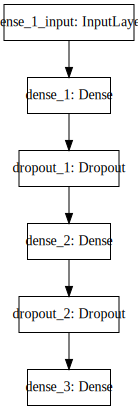

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-3, steps_per_epoch=np.ceil(60000/128), epochs=3)
model.fit(X_train, y_train, callbacks=[lr_finder] )

Epoch 1/1
60000/60000 [==============================] - 20s 332us/step - loss: 0.4061 - acc: 0.8813


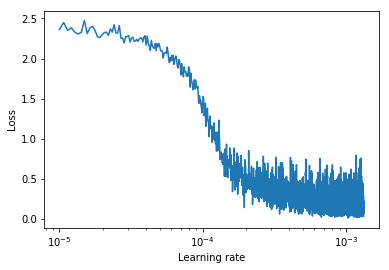

In [7]:
lr_finder.plot_loss()

In [8]:
earlystopper = EarlyStopping(monitor='val_loss',patience=5, verbose=1)

## SGDR

In [9]:
schedule = SGDRScheduler(min_lr=1e-4,max_lr=1e-3,steps_per_epoch=np.ceil(60000/128), lr_decay=0.9, cycle_length=3,mult_factor=1.5)
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), callbacks=[schedule])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.0893 - acc: 0.9731 - val_loss: 0.0718 - val_acc: 0.9776
Epoch 2/10
60000/60000 [==============================] - 8s 135us/step - loss: 0.0597 - acc: 0.9816 - val_loss: 0.0605 - val_acc: 0.9808
Epoch 3/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0454 - acc: 0.9860 - val_loss: 0.0578 - val_acc: 0.9820
Epoch 4/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0567 - acc: 0.9824 - val_loss: 0.0637 - val_acc: 0.9793
Epoch 5/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.0431 - acc: 0.9861 - val_loss: 0.0613 - val_acc: 0.9813
Epoch 6/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0311 - acc: 0.9903 - val_loss: 0.0567 - val_acc: 0.9831
Epoch 7/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.0208 - acc: 0.9939 - val_loss: 0.0547 - 

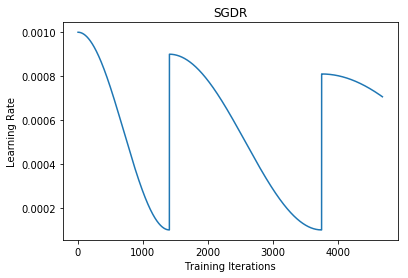

In [10]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("SGDR")
plt.plot(schedule.history['iterations'], schedule.history['lr'])

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.053515737252488906
Test accuracy: 0.9843


## CLR

In [12]:
clr_triangular = CyclicLR(mode='triangular')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1006 - acc: 0.9693 - val_loss: 0.1364 - val_acc: 0.9610
Epoch 2/10
60000/60000 [==============================] - 8s 135us/step - loss: 0.2167 - acc: 0.9405 - val_loss: 0.2511 - val_acc: 0.9321
Epoch 3/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.2493 - acc: 0.9385 - val_loss: 0.1329 - val_acc: 0.9650
Epoch 4/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.1171 - acc: 0.9692 - val_loss: 0.0777 - val_acc: 0.9783
Epoch 5/10
60000/60000 [==============================] - 8s 125us/step - loss: 0.0677 - acc: 0.9802 - val_loss: 0.0846 - val_acc: 0.9787
Epoch 6/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.1293 - acc: 0.9663 - val_loss: 0.1937 - val_acc: 0.9493
Epoch 7/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.3568 - acc: 0.9306 - val_loss: 0.1654 - 

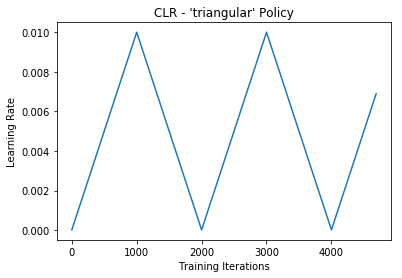

In [14]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [15]:
clr_triangular = CyclicLR(mode='triangular2')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data= (X_test, y_test), callbacks=[clr_triangular])

/Users/nathanhubens/anaconda/envs/DeepLearning/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.1079 - acc: 0.9735 - val_loss: 0.1358 - val_acc: 0.9707
Epoch 2/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.2186 - acc: 0.9579 - val_loss: 0.2218 - val_acc: 0.9600
Epoch 3/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.2820 - acc: 0.9482 - val_loss: 0.1640 - val_acc: 0.9688
Epoch 4/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.1439 - acc: 0.9697 - val_loss: 0.1144 - val_acc: 0.9758
Epoch 5/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.1053 - acc: 0.9756 - val_loss: 0.1067 - val_acc: 0.9789
Epoch 6/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0999 - acc: 0.9767 - val_loss: 0.1193 - val_acc: 0.9764
Epoch 7/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.1099 - acc: 0.9743 - val_loss: 0.1195 - 

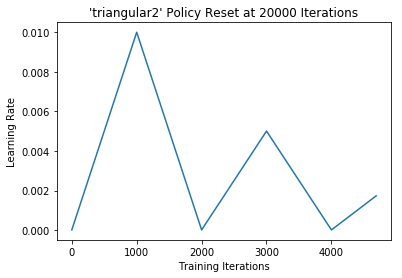

In [17]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy Reset at 20000 Iterations")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [ ]:
clr_triangular._reset()

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy Reset at 20000 Iterations")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [18]:
clr_triangular = CyclicLR(mode='exp_range', gamma=0.9994)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

/Users/nathanhubens/anaconda/envs/DeepLearning/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.0686 - acc: 0.9834 - val_loss: 0.1208 - val_acc: 0.9785
Epoch 2/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.1085 - acc: 0.9755 - val_loss: 0.1226 - val_acc: 0.9773
Epoch 3/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.1232 - acc: 0.9749 - val_loss: 0.1131 - val_acc: 0.9785
Epoch 4/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0763 - acc: 0.9827 - val_loss: 0.1033 - val_acc: 0.9810
Epoch 5/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.0596 - acc: 0.9858 - val_loss: 0.1040 - val_acc: 0.9813
Epoch 6/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0516 - acc: 0.9876 - val_loss: 0.1036 - val_acc: 0.9809
Epoch 7/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0543 - acc: 0.9869 - val_loss: 0.1015 - 

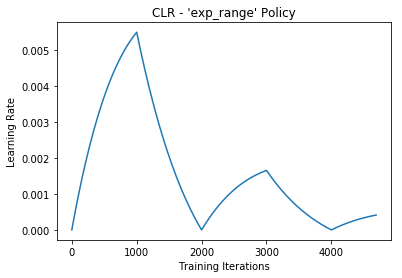

In [20]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'exp_range' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [21]:
clr_triangular._reset(new_base_lr=0.003, new_max_lr=0.009)

In [22]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 1536/60000 [..............................] - ETA: 7s - loss: 0.0278 - acc: 0.9909

/Users/nathanhubens/anaconda/envs/DeepLearning/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


60000/60000 [==============================] - 8s 127us/step - loss: 0.0937 - acc: 0.9793 - val_loss: 0.1405 - val_acc: 0.9715
Epoch 2/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.1793 - acc: 0.9661 - val_loss: 0.1621 - val_acc: 0.9677
Epoch 3/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.1392 - acc: 0.9723 - val_loss: 0.1385 - val_acc: 0.9774
Epoch 4/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0956 - acc: 0.9791 - val_loss: 0.1187 - val_acc: 0.9786
Epoch 5/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0737 - acc: 0.9835 - val_loss: 0.1289 - val_acc: 0.9784
Epoch 6/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0753 - acc: 0.9835 - val_loss: 0.1194 - val_acc: 0.9797
Epoch 7/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0775 - acc: 0.9823 - val_loss: 0.1166 - val_acc: 0.9791
Epoch 8/10
60000/60000 [=====================

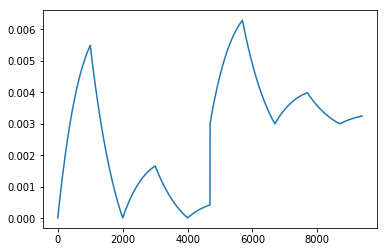

In [23]:
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [24]:
clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))

In [25]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='cycle')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

/Users/nathanhubens/anaconda/envs/DeepLearning/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.0597 - acc: 0.9868 - val_loss: 0.1502 - val_acc: 0.9766
Epoch 2/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.1565 - acc: 0.9716 - val_loss: 0.2567 - val_acc: 0.9618
Epoch 3/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.2316 - acc: 0.9598 - val_loss: 0.2029 - val_acc: 0.9693
Epoch 4/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1392 - acc: 0.9730 - val_loss: 0.1363 - val_acc: 0.9764
Epoch 5/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0934 - acc: 0.9802 - val_loss: 0.1327 - val_acc: 0.9779
Epoch 6/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0898 - acc: 0.9816 - val_loss: 0.1510 - val_acc: 0.9752
Epoch 7/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0995 - acc: 0.9801 - val_loss: 0.1421 - 

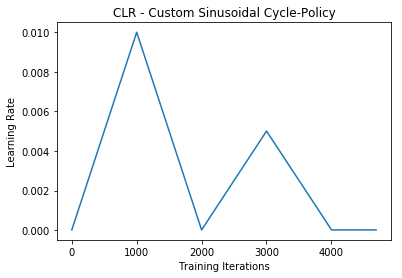

In [27]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Sinusoidal Cycle-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [28]:
clr = lambda x: 1/(5**(x*0.0001))

In [29]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='iterations')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.0610 - acc: 0.9867 - val_loss: 0.1368 - val_acc: 0.9793
Epoch 2/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.1684 - acc: 0.9720 - val_loss: 0.2014 - val_acc: 0.9725
Epoch 3/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.1959 - acc: 0.9678 - val_loss: 0.1908 - val_acc: 0.9709
Epoch 4/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.1198 - acc: 0.9776 - val_loss: 0.1433 - val_acc: 0.9794
Epoch 5/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0855 - acc: 0.9835 - val_loss: 0.1357 - val_acc: 0.9789
Epoch 6/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0943 - acc: 0.9824 - val_loss: 0.1690 - val_acc: 0.9763
Epoch 7/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.1226 - acc: 0.9772 - val_loss: 0.1446 - 

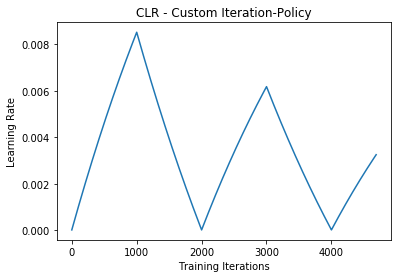

In [31]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Iteration-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])